# Visualize a 1D neural network

Optimization and interactive control of a 1D -> 1D neural network function.

[[**Open this notebook in Colab**]](https://colab.research.google.com/github/hhoppe/visualize_neural_network/blob/main/visualize_neural_network.ipynb)

## Preamble

In [1]:
# pylint: disable=missing-function-docstring, global-statement, redefined-outer-name

import contextlib
import math

import IPython.display
import ipywidgets
import matplotlib.pyplot as plt
import networkx
import numpy as np
import torch

In [2]:
SHOW_SLIDERS = True
VERBOSE = False
R = 10

In [3]:
# Numbers of nodes in each layer of the neural network (layer 0 is input, last layer is output):
# LAYER_SIZES = 1, 3, 1
LAYER_SIZES = 1, 2, 2, 1
# LAYER_SIZES = 1, 3, 3, 1
# LAYER_SIZES = 1, 4, 4, 1
# LAYER_SIZES = 1, 4, 4, 4, 1  # It is best to set SHOW_SLIDERS=False.

## Target functions

In [4]:
TARGETS = {
    'sine': lambda x: np.sin(math.tau * x),
    'cosine': lambda x: np.cos(math.tau * x),
    'triangle': lambda x: 1 - 2 * np.abs(x - 0.5),
    'half-sine': lambda x: np.sin(math.tau / 2 * x),
}

## Activation functions

In [5]:
def relu(x):
  return torch.nn.functional.relu(x) if isinstance(x, torch.Tensor) else np.maximum(0, x)


def leaky_relu(x, negative_slope=0.1):
  if isinstance(x, torch.Tensor):
    return torch.nn.functional.leaky_relu(x, negative_slope=negative_slope)
  return np.maximum(x * negative_slope, x)


def identity(x):
  return x


def sigmoid(x):
  return torch.sigmoid(x) if isinstance(x, torch.Tensor) else 1 / (1 + np.exp(-x))


ACTIVATIONS = {'relu': relu, 'leaky_relu': leaky_relu, 'identity': identity, 'sigmoid': sigmoid}

## Neural network

In [6]:
# The dictionary `params` contains weights 'w{layer}{curr_index}{prev_index}' and
# biases 'b{layer}{index}', as either float values or (scalar) torch tensors.
def neural_network(inputs, params, activations, output_layer_index=10**9):
  assert len(inputs) == LAYER_SIZES[0]
  outputs = inputs
  for layer_index, layer_size in enumerate(LAYER_SIZES[1 : output_layer_index + 1], 1):
    activation = activations[layer_index]
    nodes = []
    for node_index in range(layer_size):
      linear = sum(
          params[f'w{layer_index}{node_index}{prev_index}'] * prev_node
          for prev_index, prev_node in enumerate(outputs)
      )
      node = activation(linear + params[f'b{layer_index}{node_index}'])  # type: ignore[operator]
      nodes.append(node)
    outputs = nodes
  return outputs

## Params initialization

In [7]:
def get_reset_params():
  d: dict[str, float] = {}

  if LAYER_SIZES == (1, 3, 1):
    d |= dict(w100=1.3, b10=-0.2, w110=3.0, b11=-2.1, w120=2.5, b12=-1.0)
    d |= dict(w200=7.0, w201=4.0, w202=-5.8, b20=-1.0)

  elif LAYER_SIZES == (1, 2, 2, 1):
    d |= dict(w100=-3.45, b10=2.38, w110=6.88, b11=-2.76)
    d |= dict(w200=-1.40, w201=-0.59, b20=2.03, w210=-0.78, w211=-0.50, b21=1.48)
    d |= dict(w300=1.93, w301=-1.15, b30=0.17)

  else:
    rng = np.random.default_rng(0)  # Deterministic.
    for layer_index, layer_size in enumerate(LAYER_SIZES[1:], 1):
      for node_index in range(layer_size):
        for prev_index in range(LAYER_SIZES[layer_index - 1]):
          d[f'w{layer_index}{node_index}{prev_index}'] = rng.random() * 2 - 1
        d[f'b{layer_index}{node_index}'] = rng.random() * 2 - 1

  return d

## Neural network optimization

In [8]:
def fit_neural_network(params, activations, target_function, num_steps=1500):
  tensor_params = {
      key: torch.tensor([value], dtype=torch.float32, requires_grad=True)
      for key, value in params.items()
  }
  variables = list(tensor_params.values())
  x_train = torch.linspace(0, 1, 100, dtype=torch.float32)
  y_train = target_function(x_train)

  learning_rate = 0.01
  optimizer = torch.optim.Adam(variables, lr=learning_rate)
  for step in range(num_steps):
    optimizer.zero_grad()
    (y_pred,) = neural_network([x_train], tensor_params, activations)
    loss = torch.mean((y_train - y_pred) ** 2)
    loss.backward()
    optimizer.step()
    if VERBOSE and step % 100 == 0:
      print(f'Step {step}, Loss: {loss.item()}')  # See messages using "log" icon.

  return {key: tensor.detach().numpy().item() for key, tensor in tensor_params.items()}

## User interface

In [9]:
def display_network_graph():
  graph = networkx.DiGraph()
  pos = {}
  for layer_index, layer_size in enumerate(LAYER_SIZES):
    for node_index in range(layer_size):
      graph.add_node(node := f'n{layer_index}{node_index}')
      pos[node] = layer_index * 6, ((layer_size - 1) / 2 - node_index) * 4
      if layer_index > 0:
        for prev_index in range(LAYER_SIZES[layer_index - 1]):
          label = f'w{layer_index}{node_index}{prev_index}'
          graph.add_edge(f'n{layer_index - 1}{prev_index}', node, label=label)

  _, ax = plt.subplots(figsize=(12, 6), dpi=70)
  networkx.draw(graph, pos, ax=ax, node_size=800, node_color='lightblue', with_labels=True)
  edge_labels = networkx.get_edge_attributes(graph, 'label')
  networkx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=12)
  plt.show()

In [16]:
class MainPlot:
  """User interface for main plot."""

  def __init__(self):
    self.params = get_reset_params()
    self.target_selector = ipywidgets.RadioButtons(
        options=list(TARGETS), value='sine', description='Target function:'
    )
    self.activation_selector = ipywidgets.RadioButtons(
        options=list(ACTIVATIONS), value='leaky_relu', description='Activation function:'
    )
    self.layer_selector = ipywidgets.RadioButtons(
        options=range(len(LAYER_SIZES)), value=len(LAYER_SIZES[1:]), description='Plot layer:'
    )
    self.sliders = self.create_sliders() if SHOW_SLIDERS else {}
    self.center_button = ipywidgets.Button(description='Center slider ranges')
    self.reset_button = ipywidgets.Button(description='Reset params')
    self.randomize_button = ipywidgets.Button(description='Randomize params')
    self.fit_button = ipywidgets.Button(description='Fit target')
    self.output = ipywidgets.Output()
    self.textarea = ipywidgets.Textarea(
        rows=len(LAYER_SIZES[1:]), layout={'width': '800px'}, disabled=True
    )

    self.target_selector.observe(lambda change: self.update_plot(), names='value')
    self.activation_selector.observe(lambda change: self.update_plot(), names='value')
    self.layer_selector.observe(lambda change: self.update_plot(), names='value')
    for slider in self.sliders.values():
      slider.observe(lambda change: self.on_slider_change(), 'value')
    self.center_button.on_click(lambda button: self.center_slider_range())
    # (Due to a bug in slider value update, we may need to press a button more than once.)
    self.reset_button.on_click(lambda button: self.reset_parameters())
    self.randomize_button.on_click(lambda button: self.randomize_parameters())
    self.fit_button.on_click(lambda button: self.fit_target())

  def create_sliders(self):
    a = dict(step=0.01, continuous_update=True)
    return {
        key: ipywidgets.FloatSlider(value=value, min=value - R, max=value + R, description=key, **a)
        for key, value in self.params.items()
    }

  def get_activations(self):
    return [ACTIVATIONS[self.activation_selector.value]] * (len(LAYER_SIZES) - 1) + [identity]

  def update_plot(self):
    text_lines = []
    for layer_index in range(1, len(LAYER_SIZES)):
      t = ', '.join(f'{k}={v:.2f}' for k, v in self.params.items() if int(k[1]) == layer_index)
      text_lines.append(f'dict({t})')
    self.textarea.value = '\n'.join(text_lines)
    with self.output:
      self.output.clear_output(wait=True)
      _, ax = plt.subplots(figsize=(10, 5))
      x = np.linspace(0, 1, 100)
      ax.plot(x, TARGETS[self.target_selector.value](x), lw=0.5, label='target')
      output_layer_index = self.layer_selector.value
      output_nodes = neural_network(
          [x], self.params, self.get_activations(), output_layer_index=output_layer_index
      )
      for node_index, node in enumerate(output_nodes):
        ax.plot(x, node, label=f'node n{output_layer_index}{node_index}')
      ax.set(xlabel='x', ylabel='y=f(x)', ylim=(-2, 2))
      ax.grid(True)
      ax.legend(loc='upper right')
      plt.show()

  def update_params(self, new_params, center_sliders=True):
    self.params = new_params
    if SHOW_SLIDERS:
      with contextlib.ExitStack() as stack:
        for slider in reversed(self.sliders.values()):
          stack.enter_context(slider.hold_trait_notifications())
        for key, slider in self.sliders.items():
          value = self.params[key]
          if slider.value != value:  # Not sure if test is useful.
            slider.value = value  # Bug: https://github.com/jupyter-widgets/ipywidgets/issues/3824.
          if center_sliders:
            slider.min = value - R
            slider.max = value + R
    self.update_plot()

  def on_slider_change(self):
    self.update_params(
        {key: slider.value for key, slider in self.sliders.items()}, center_sliders=False
    )

  def center_slider_range(self):
    for slider in self.sliders.values():
      slider.min, slider.max = slider.value - R, slider.value + R

  def reset_parameters(self):
    self.update_params(get_reset_params())

  def randomize_parameters(self):
    rng = np.random.default_rng()  # Non-deterministic.
    self.update_params({key: rng.random() * 2 - 1 for key in self.params})

  def fit_target(self):
    self.update_params(
        fit_neural_network(self.params, self.get_activations(), TARGETS[self.target_selector.value])
    )

  def display(self):
    self.reset_parameters()
    selectors = ipywidgets.HBox(
        [self.target_selector, self.activation_selector, self.layer_selector]
    )
    layers = [ipywidgets.Label('Weight and bias parameters in each network layer:')]
    for layer_index in range(1, len(LAYER_SIZES)):
      layer_sliders = [slider for key, slider in self.sliders.items() if int(key[1]) == layer_index]
      layers.append(ipywidgets.HBox([ipywidgets.Label(f'Layer {layer_index}:')] + layer_sliders))
    buttons = ipywidgets.HBox(
        [self.center_button, self.reset_button, self.randomize_button, self.fit_button]
    )
    rows = [selectors, *layers, buttons, self.output, self.textarea]
    return ipywidgets.VBox(rows)

In [17]:
main_plot = MainPlot()

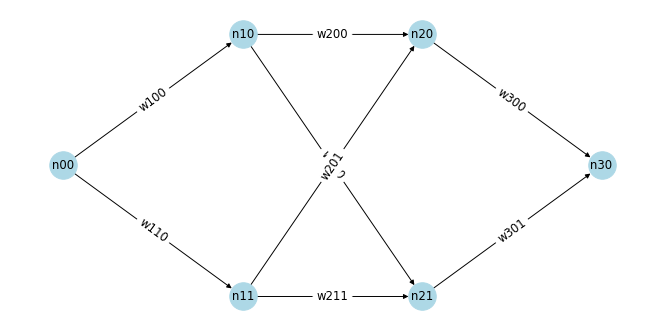

In [18]:
display_network_graph()

In [19]:
main_plot.display()

# End

<!-- For Emacs:
Local Variables:
fill-column: 100
End:
-->